In [2]:
import gc
import json
import pickle as pk
import random
import re
import time
from collections import Counter

import cv2
import easyocr
import matplotlib.pyplot as plt
import numpy as np
import PIL
import pytesseract
import requests
import torch
from IPython.display import HTML
from matplotlib import animation
from transformers import (
    AutoModel,
    AutoModelForCausalLM,
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    pipeline,
)
from vidaug import augmentors as va

In [3]:
with open("../training/data/data_sampled_threshold_10.pkl", "rb") as f:
    X_data, Y_data = pk.load(f)

X_data[0]

'/home/lehoangchibach/Documents/Code/gif_analytics/templates/template_examples/91be88e0f31f774344846969c8931594_315139414.gif'

In [71]:
NUM_FRAMES = 5
IMAGE_SIZE = (224, 224)


def first_frame(video_path):
    cap = cv2.VideoCapture(video_path)

    # Check if the video was successfully opened
    if not cap.isOpened():
        raise Exception("Error: Could not open video.")
    else:
        # Read the first frame
        ret, frame = cap.read()
    cap.release()
    return frame


def draw_video(video, interval=250):
    fig = plt.figure()
    im = plt.imshow(video[0, :, :, :])

    plt.close()  # this is required to not display the generated image

    def init():
        im.set_data(video[0, :, :, :])

    def animate(i):
        im.set_data(video[i, :, :, :])
        return im

    anim = animation.FuncAnimation(
        fig, animate, init_func=init, frames=video.shape[0], interval=interval
    )
    return HTML(anim.to_html5_video())


def train_video_processor(video_path: str) -> np.ndarray:
    frames = []
    cap = cv2.VideoCapture(video_path)

    # Get total number of frames
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if total_frames <= 0:
        raise ValueError("Could not read frames from video file")

    # Calculate frame indices to extract
    frame_indices = [
        i * (total_frames - 1) // (NUM_FRAMES - 1) for i in range(NUM_FRAMES)
    ]

    for frame_idx in frame_indices:
        # Set frame position
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)

        # Read frame
        ret, frame = cap.read()
        if ret:
            # Convert BGR to RGB
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            frames.append(frame_rgb)

    # Release video capture object
    cap.release()

    while len(frames) < 5:
        frames.append(frames[-1])

    seq = va.Sequential(
        [
            va.Pepper(),
            va.RandomShear(x=0.2, y=0.2),
            va.RandomTranslate(x=10, y=10),
            va.RandomRotate(20),
            va.Sometimes(0.5, va.HorizontalFlip()),
        ]
    )

    frames = seq(frames)
    # video_data = np.stack(frames)
    # video_data.astype(np.float32)

    res = []
    for frame in frames:
        res.append(cv2.resize(frame, IMAGE_SIZE))
    return np.array(res)

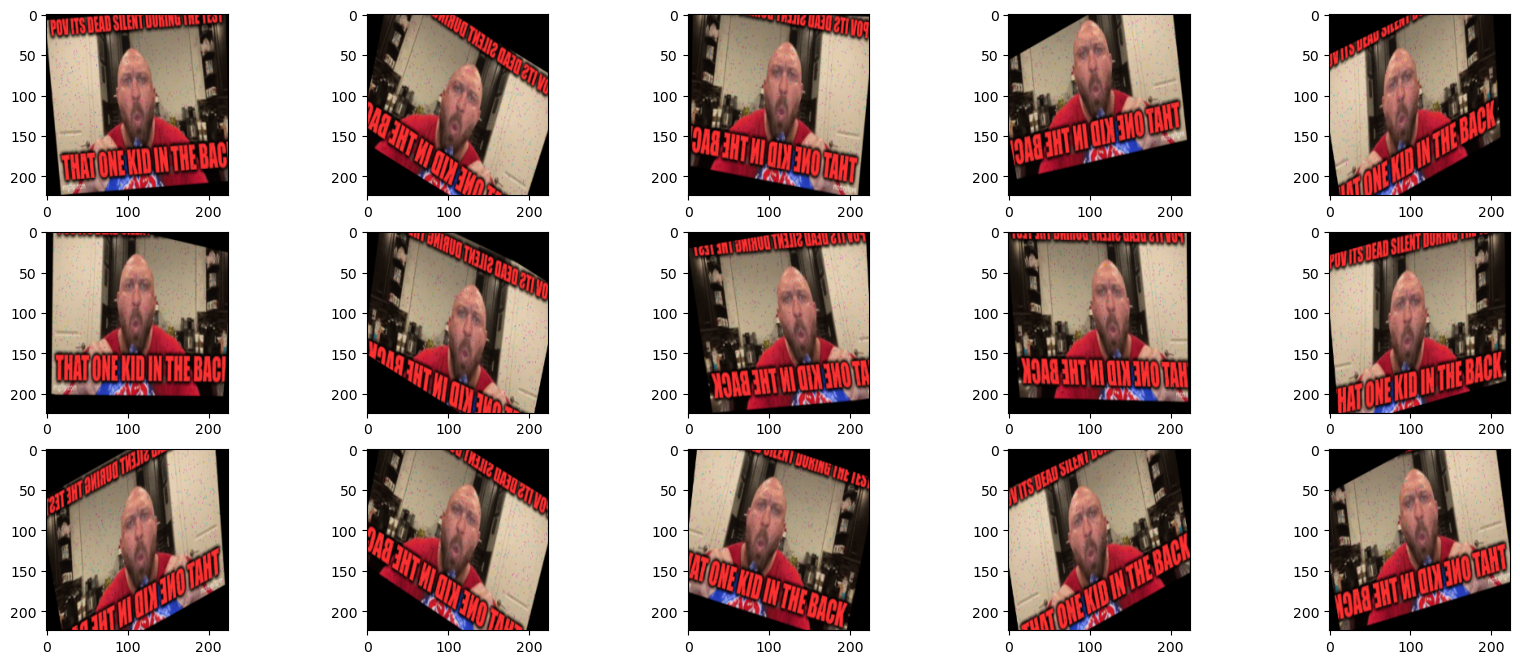

In [72]:
fig, axs = plt.subplots(3, 5, figsize=(20, 8))
for i, ax in enumerate(axs.flat):
    video_data = train_video_processor(X_data[0])
    image = video_data[0]
    ax.imshow(image)

plt.show()

['"Ipay for', 'poy Ior ImgHip', 'imgflip pro to', 'to support Iho', 'dcvolopcrs and thonk thcm', 'remove the watermark"', '{or nohlmg an owozomo zito', 'ncip.com', 'pro']
"Ipay for poy Ior ImgHip imgflip pro to to support Iho dcvolopcrs and thonk thcm remove the watermark" {or nohlmg an owozomo zito ncip.com pro


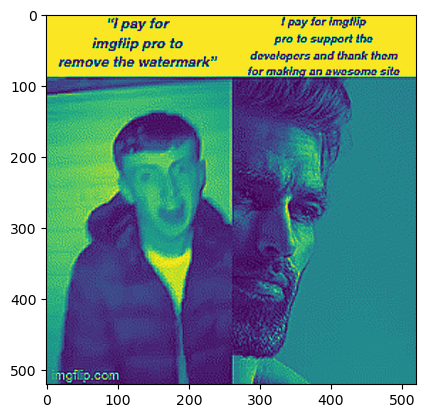

In [5]:
image = first_frame(X_data[4])

# PRE PROCESS
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# _, image = cv2.threshold(image, 110, 255, cv2.THRESH_BINARY)
resize = 2
image = cv2.resize(image, None, fx=resize, fy=resize, interpolation=cv2.INTER_CUBIC)

surround = -1
center = (-surround) * 8 + 1
kernel = np.array(
        [
            [surround, surround, surround],
            [surround, center, surround],
            [surround, surround, surround],
        ]
    )
image = cv2.filter2D(image, -1, kernel)


reader = easyocr.Reader(["en"])
result = reader.readtext(image, detail=0)

print(result)
print(" ".join(result))
plt.imshow(image)

In [7]:
def clean_up(text):
    messages = [
        {
            "role": "system",
            "content": """
         You are receiving extracted text from a meme. 
         Perform clean up, correct on text and remove any gibberish in it. You are allowed to change very small typo to make the sentence understandable. 
         Do not add new words or sentences. Do not change the structure of the text.
         Return only the cleaned up text. If you are not able to clean it up, return empty string only.
         Your response must be in the following json format.
         =====
         Return json format:
         {
         "text": "the clean up text here"
         }
        """,
        },
        {"role": "user", "content": text},
    ]
    response = requests.post(
        "http://localhost:11434/api/chat",
        json={"model": "llama3.2:3b", "messages": messages, "stream": False},
        # json={"model": "llama3.1:8b", "messages": messages, "stream": False},
    )

    if response.status_code == 200:
        content = response.json()["message"]["content"]
        try:
            return json.loads(content)["text"]
        except Exception:
            return clean_up(text)
    else:
        print(f"Error: {response.status_code} - {response.text}")

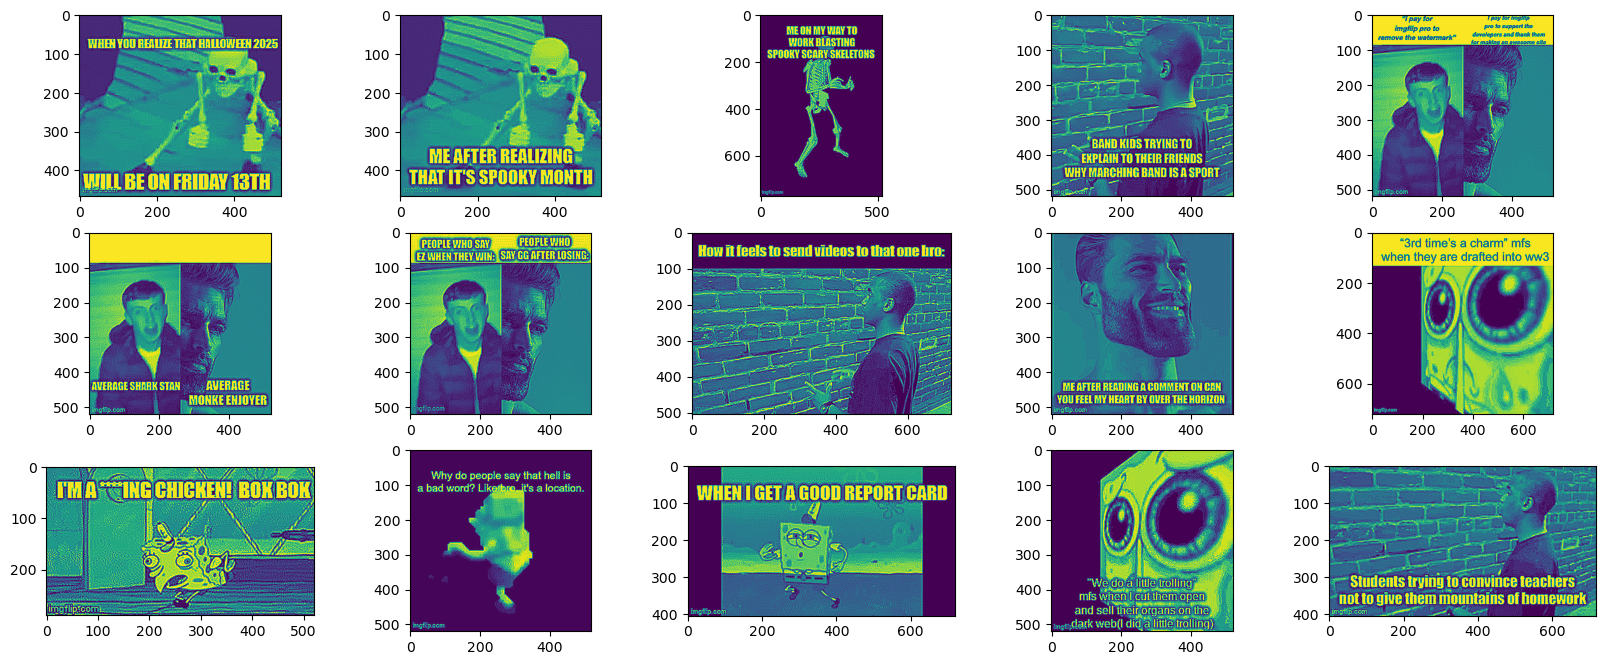

['WHEYODAEWZ THATHAWOWE2025 WLBE ONFRIDAY 13TH',
 'ME AFTER REALIZING THAT ITS SPOOKY MONTH n1g7pccn',
 'ME ON MY WVAY TO WORKBLASTING SPOOKY SCARYSKELETONS mcifoccn',
 'BAND KIDS TRYING TO  EXPLAUIH TO THEIR FRIENDS WHY MARCHIHG BAND IS A SPORT icfpeow',
 '"Ipay for poy Iar Imgkip imgtlip pro to fo support Ito remove the watermark" dcvlopors dnd {honk Ihom {or nhlt anowozono gito com pro Lmciip.',
 'AVERAGE SHARK STAN AVERAGE MONKE ENJOYER ingifp.cam',
 'PEOPLE WHO SAY PEOPLEWVHO EZWHENTHEYWIN: SAYGGAFER LOSQG? nciecom',
 'How @t feelsto sendvideosto thatone Dro:',
 'MEAFER READINGA COMMEHT OH CAH YOUFEELMY HEARTBY OVER TAEHORDON lingffp.ccm',
 '"3rd time\'s a charm" mfs when are drafted into WW3 igfpcom they',
 'IMA TNACHCKEN BORBOK ingflipcom',
 "Why do people say that hell is bad word? Like bra it's a location: icioxcm",
 'WHEN I GET A GOOD REPORT CARD ingffp.com',
 '\'We doa litle tolling" mfs when I cut them open and sell their organs 0n the ingi dark web(l did a little trolling)

In [12]:
fig, axs = plt.subplots(3, 5, figsize=(20, 8))
texts = []
reader = easyocr.Reader(["en"])
for i, ax in enumerate(axs.flat):
    image = first_frame(X_data[i])

    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    resize = 2
    image = cv2.resize(image, None, fx=resize, fy=resize, interpolation=cv2.INTER_CUBIC)

    surround = -2
    center = (-surround) * 8 + 1
    kernel = np.array(
            [
                [surround, surround, surround],
                [surround, center, surround],
                [surround, surround, surround],
            ]
        )
    image = cv2.filter2D(image, -1, kernel)

    ax.imshow(image)

    text = reader.readtext(image, detail=0)
    text = " ".join(text)
    # text = clean_up(text)
    texts.append(text)

plt.show()
texts

In [25]:
%%time
texts = {}
for i, path in enumerate(X_data):
    image = first_frame(X_data[i])

    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    resize = 2
    image = cv2.resize(image, None, fx=resize, fy=resize, interpolation=cv2.INTER_CUBIC)
    
    surround = -2
    center = (-surround) * 8 + 1
    kernel = np.array(
            [
                [surround, surround, surround],
                [surround, center, surround],
                [surround, surround, surround],
            ]
        )
    image = cv2.filter2D(image, -1, kernel)
    
    ax.imshow(image)
    
    text = reader.readtext(image, detail=0)
    text = " ".join(text)
    texts[path] = text


CPU times: user 12min 18s, sys: 1min 21s, total: 13min 39s
Wall time: 20min 32s


In [26]:
X_data.shape

(10165,)

In [27]:
texts

{'/home/lehoangchibach/Documents/Code/gif_analytics/templates/template_examples/91be88e0f31f774344846969c8931594_315139414.gif': 'POV Iis @EED SILENT DURING THE TEST 1 THAT ONE [d IN THE BaCK Lugipccm Xv> IILe',
 '/home/lehoangchibach/Documents/Code/gif_analytics/templates/template_examples/4bca24304861acde5770fdbe3cc2503b_465397633.gif': 'the shampoo bottles after won rock paper scissors against the mirror meip com',
 '/home/lehoangchibach/Documents/Code/gif_analytics/templates/template_examples/ec3ed227a929e370b37671b48317f54e_297499890.gif': 'FAREROFASCVHEN THE WEEKCND PERFORNISTHEMORNINGQVE Ee_',
 '/home/lehoangchibach/Documents/Code/gif_analytics/templates/template_examples/4def363f5a7a1dc58d11890fa3b0ec94_224897138.gif': 'dd 1 "Slou-Roast Ghicken"? d0 But WVe anna Eat Now E TNo [lorries, _ Dudes 00 and Dudettes [ive Got You Mly',
 '/home/lehoangchibach/Documents/Code/gif_analytics/templates/template_examples/c5ee6be7162f29471bb74f14c81472fe_277506904.gif': 'MY REACTION TO THAT IN

In [28]:
len(texts)

10021

In [34]:
with open("./outputs/ocr_texts.json", "w") as f:
    json.dump(texts, f)